# Libraries

In [18]:
# Data-handling libraries
import pandas as pd

# Text-handling libraries
from nltk.tokenize import RegexpTokenizer

# Reshaping imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Other imports
import re

# Options
seed = 5777

# Data Import

In [3]:
# Data source: http://menus.nypl.org/data
menu = pd.read_csv("data/Menu.csv.bz2")
dish = pd.read_csv("data/Dish.csv.bz2")
menu_item = pd.read_csv("data/MenuItem.csv.bz2")
menu_page = pd.read_csv("data/MenuPage.csv.bz2")

# Data Cleaning

## Shape data

In [4]:
# Merge datasets 
df = pd.merge(
    menu_item[["dish_id", "menu_page_id"]],
    menu_page[["id", "menu_id"]],
    how = "right",
    left_on = "menu_page_id",
    right_on = "id"
)
df = pd.merge(
    df,
    menu[["id", "date"]],
    how = "right",
    left_on = "menu_id",
    right_on = "id"
)
df = pd.merge(
    df,
    dish[["id", "name"]],
    how = "right",
    left_on = "dish_id",
    right_on = "id"
)

df = df[["name", "date"]]

# Delete our original imports to free up memory
del menu
del dish
del menu_item
del menu_page

In [5]:
# Drop malformed dates
df["date"] = pd.to_datetime(df["date"], errors="coerce")

In [6]:
# Drop 68438 unknown and 638 malformed dates (≈ 5%)
df.dropna(inplace=True)

In [7]:
# Calculate year and decade
df["year"] = pd.DatetimeIndex(df["date"]).year
df["decade"] = np.round(df["year"], -1)

## Replace special characters

In [8]:
# Fractions
df["name"] = df["name"].str.replace("[½]", '1/2')

# Curly quotes
df["name"] = df["name"].str.replace("[“”„]", '"')

# Letters with diacricics
# df["name"] = df["name"].str.replace("[Ää]",   "ae")
# df["name"] = df["name"].str.replace("[Éèéê]", "e")
# df["name"] = df["name"].str.replace("[Îï]",   "i")
# df["name"] = df["name"].str.replace("[Öö]",   "oe")
# df["name"] = df["name"].str.replace("[Ü]",    "ue")
# df["name"] = df["name"].str.replace("[ß]",    "ss")
# df["name"] = df["name"].str.replace("[àáâå]", "a")
# df["name"] = df["name"].str.replace("[ç]",    "c")
# df["name"] = df["name"].str.replace("[óø]",   "o")
# df["name"] = df["name"].str.replace("[û]",    "u")
# df["name"] = df["name"].str.replace("[Œœ]",   "oe")
# df["name"] = df["name"].str.replace("[Śś]",   "s")
# df["name"] = df["name"].str.replace("[ź]",    "z")

In [9]:
# Foreign scripts can be REALLY hard to work with, so we drop them

# Greek
df = df[~df["name"].str.contains("[ΑΓΔΕΖΘΙΚΛΜΝΟΠΣΤΥΧΨΩάίαγδεηθιλνξοπρςστυχωϊό]")]

# Devanagari
df = df[~df["name"].str.contains("[ईककीकोखगीचचाचेजजिणतताथथॅददादुदूननंनानीनूपपाबाबीभोमैररीललालीलूलेळवाशीशुससीसोहिं१२३४७]")]

# Han
df = df[~df["name"].str.contains("[丁三上串五什仁保公冬包半卷司吐吞哲大夫子宫尾巴廣手抄拌排春景會木東松果栗檬檸水油洋海涼清湯火炒炸烤煙燒爆片牛玉瓜白磨竹米紅素紫絲绦翅肉肚腐腰腿芥花茸菇菜蔴蘭蛋蝦西豆貼賓辣酸醉醬鍋雙雞雲青須餃香骨魚鮑鮮鳳鴨鷄鹹麵]")]

In [10]:
# Confirm that we got all non-ASCII characters
df[df["name"].str.contains("[^\x00-\x7F]")]

,name,date,year,decade
58782,"Moët & Chandon, Brut, White Seal",1900-04-09,1900,1900
59104,"Médoc, Cruse & Fils Frères",1900-04-09,1900,1900
59105,"Médoc, Cruse & Fils Frères",1900-04-09,1900,1900
59106,"Médoc, Cruse & Fils Frères",1900-09-03,1900,1900
59107,"Médoc, Cruse & Fils Frères",1900-01-17,1900,1900
59108,"Médoc, Cruse & Fils Frères",1900-02-12,1900,1900
59109,"Médoc, Cruse & Fils Frères",1899-10-17,1899,1900
59110,"Médoc, Cruse & Fils Frères",1899-10-17,1899,1900
59111,"Médoc, Cruse & Fils Frères",1899-04-16,1899,1900
59112,"Médoc, Cruse & Fils Frères",1898-05-01,1898,1900


## Tokenize etc.

In [11]:
def cleanText(text):
    tok = RegexpTokenizer("[a-z'-]+")
    return " ".join(tok.tokenize(text.lower()))

df["name"] = df["name"].apply(cleanText)

## Write out cleaned data

In [12]:
df.drop(columns="date").to_csv("data/Dishes-by-year.csv.bz2", compression="bz2")

# EDA

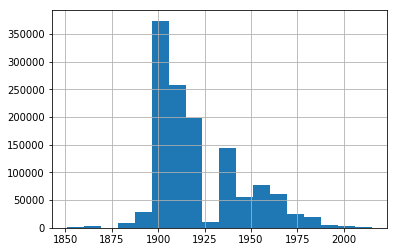

In [14]:
df["year"].hist(bins=18); # 18 decades are represented

# Model data

## Split data

In [16]:
X = df["name"]
y = df["decade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)

## Define models

In [28]:
cv_folds = 3

pipe = Pipeline([
        ("cvec", CountVectorizer()),
        #("ss", StandardScaler()),
        ("rf", RandomForestClassifier())
    ])
params = {
     #"cvec__max_features": [2000, 3000, 4000],
     "cvec__ngram_range": [(1,1), (1,2), (1, 3), (2, 3), (1, 4)],
     "cvec__min_df": [0.01],
     "cvec__max_df": [0.99],
     #"cvec__stop_words": [None, stopwords.words("english")],
    "rf__n_estimators": [5, 10],
}

grid = GridSearchCV(pipe, params, cv=cv_folds, verbose=3)

## Run models

In [ ]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] cvec__max_df=0.99, cvec__min_df=0.01, cvec__ngram_range=(1, 1), rf__n_estimators=5 
[CV]  cvec__max_df=0.99, cvec__min_df=0.01, cvec__ngram_range=(1, 1), rf__n_estimators=5, score=0.334674506404337, total=  31.7s
[CV] cvec__max_df=0.99, cvec__min_df=0.01, cvec__ngram_range=(1, 1), rf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.9s remaining:    0.0s


[CV]  cvec__max_df=0.99, cvec__min_df=0.01, cvec__ngram_range=(1, 1), rf__n_estimators=5, score=0.3346818521612946, total=  32.9s
[CV] cvec__max_df=0.99, cvec__min_df=0.01, cvec__ngram_range=(1, 1), rf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


In [ ]:
grid.best_sc

# Evaluate Models